In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2

## Labels

In [2]:
labels = os.listdir(r"dataset\train")

In [3]:
labels

['Closed', 'no_yawn', 'Open', 'yawn']

## Visualize A random image

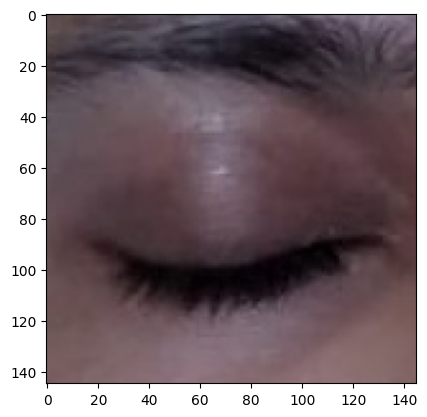

In [4]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread(r"dataset\train\Closed\_0.jpg"))

## Image array

In [5]:
a = plt.imread(r"dataset\train\yawn\10.jpg")

## Image shape

In [6]:
a.shape

(480, 640, 3)

## Visualize yawn image(Background is unnecessary. We need only face image array) 


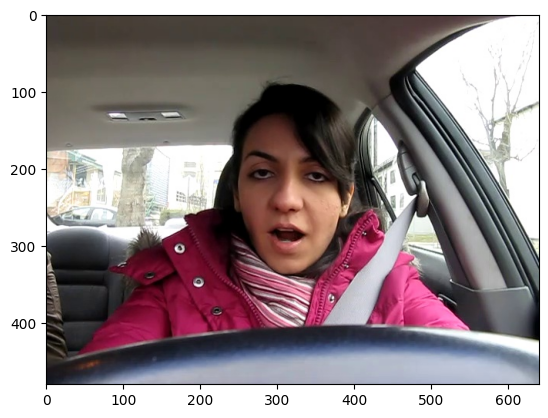

In [7]:
plt.imshow(plt.imread(r"dataset\train\yawn\10.jpg"))

## Take only face(For yawn and not_yawn)

In [8]:
def face_for_yawn(direc=r"dataset/train", face_cas_path=r"data/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    face_cascade = cv2.CascadeClassifier(face_cas_path)

    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)

        for image in os.listdir(path_link):
            try:
                image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
                faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
                for (x, y, w, h) in faces:
                    roi_color = image_array[y:y+h, x:x+w]
                    resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                    if resized_array.shape == (145, 145, 3):
                        yaw_no.append([resized_array, class_num1])
            except Exception as e:
                print(f"Error processing {image}: {e}")
    return yaw_no


## For Closed and Open eye

In [9]:
def get_data(dir_path=r"dataset/train", face_cas=r"data/haarcascade_frontalface_default.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []

    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label) + 2
        print(class_num)

        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                if resized_array.shape == (145, 145, 3):
                    data.append([resized_array, class_num])
            except Exception as e:
                print(f"Error processing {img}: {e}")
    return data


In [10]:
data_train = get_data()

2
3


## Extend data and Convert array

In [11]:
def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no, dtype=object)  # Use dtype=object to avoid shape errors

## New variable to store

In [12]:
new_data = append_data()

0
1
2
3


## Separate label and features

In [13]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

## Reshape the Array

In [14]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

## LabelBinarizer

In [15]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

## Label array

In [16]:
y = np.array(y)

## Train Test split

In [17]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

## Length of X_test

In [18]:
len(X_test)

578

## Import some dependencies

In [19]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

## Data Augmentation

In [20]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)


#train_generator = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_generator = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [21]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(145,145,3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

C:\Users\A\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 143, 143, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 71, 71, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 69, 69, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 34, 34, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 495,140 (1.89 MB)

 Trainable params: 495,140 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

C:\Users\A\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.3875 - loss: 1.3973 - val_accuracy: 0.5346 - val_loss: 1.2176
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.5801 - loss: 1.0659 - val_accuracy: 0.8426 - val_loss: 0.5311
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.7929 - loss: 0.5562 - val_accuracy: 0.8564 - val_loss: 0.3815
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.8353 - loss: 0.4309 - val_accuracy: 0.8806 - val_loss: 0.3083
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.8552 - loss: 0.3699 - val_accuracy: 0.8893 - val_loss: 0.2828
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.8811 - loss: 0.2922 - val_accuracy: 0.8858 - val_loss: 0.2745
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - accuracy: 0.8732 - loss: 0.3224 - val_accuracy: 0.9170 - val_loss: 0.2348
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.8953 - loss: 0.2638 - val_accuracy: 0.9152 - v

## History

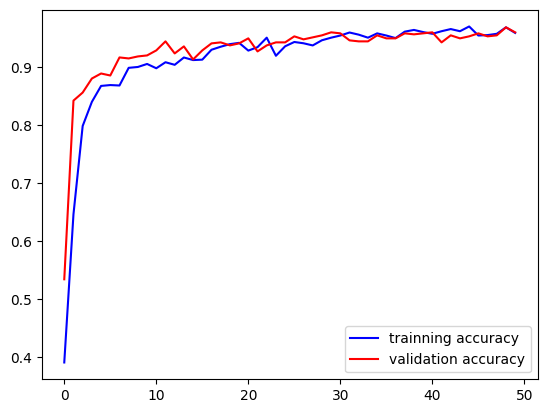

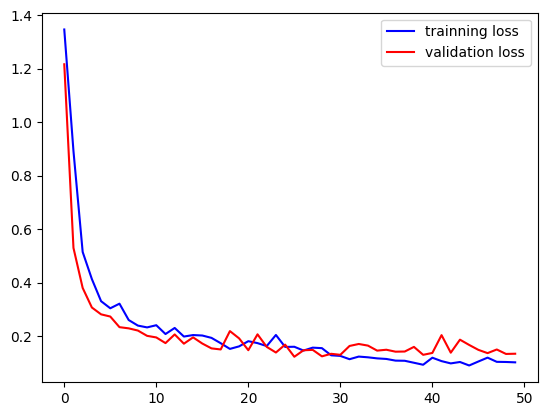

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

## Save Model

In [24]:
model.save("drowiness_new7.h5")

In [26]:
model.save("drowiness_new7.keras")

# Prediction

In [28]:
prediction = np.argmax(model.predict(X_test), axis=-1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 630ms/step


In [29]:
prediction

array([3, 3, 2, 3, 1, 3, 3, 2, 0, 2, 3, 3, 3, 2, 2, 2, 3, 0, 0, 3, 1, 3,
       2, 1, 1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 3, 3, 2, 1, 3, 2, 3, 2, 3,
       2, 2, 3, 3, 2, 3, 3, 1, 2, 1, 3, 3, 2, 2, 2, 0, 3, 3, 1, 2, 2, 3,
       2, 3, 2, 2, 1, 3, 3, 3, 2, 0, 1, 3, 1, 3, 2, 0, 3, 2, 2, 2, 2, 1,
       3, 2, 2, 3, 3, 3, 1, 0, 3, 0, 3, 3, 3, 1, 3, 1, 2, 3, 3, 1, 2, 2,
       1, 1, 2, 0, 0, 3, 3, 3, 2, 2, 3, 3, 2, 0, 1, 2, 3, 3, 2, 0, 3, 3,
       1, 3, 1, 2, 3, 3, 2, 1, 2, 2, 2, 1, 3, 3, 2, 3, 2, 0, 2, 3, 3, 3,
       3, 1, 1, 0, 3, 1, 3, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 1, 2, 0, 3, 3,
       2, 2, 0, 2, 3, 0, 2, 1, 3, 2, 3, 1, 2, 1, 1, 3, 2, 2, 2, 3, 2, 0,
       3, 2, 3, 0, 2, 0, 0, 1, 2, 3, 2, 0, 3, 1, 2, 2, 2, 2, 1, 3, 1, 0,
       1, 0, 2, 3, 3, 3, 3, 0, 1, 2, 1, 0, 3, 3, 0, 3, 3, 0, 3, 3, 0, 1,
       0, 0, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 0, 2, 2, 2, 0, 3, 3, 2, 2,
       3, 2, 2, 0, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 0, 1, 1, 3, 3, 3, 3, 2,
       2, 1, 2, 2, 2, 3, 2, 0, 2, 2, 1, 3, 2, 3, 1,

# classification report

In [30]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [31]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.82      0.79      0.81        63
     no_yawn       0.81      0.86      0.84        74
      Closed       0.93      0.98      0.95       215
        Open       0.98      0.92      0.95       226

    accuracy                           0.92       578
   macro avg       0.89      0.89      0.89       578
weighted avg       0.92      0.92      0.92       578



# predicting function

In [33]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("drowiness_new7.h5")

# Prediction 
## 0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [34]:
# prepare("../input/drowsiness-dataset/train/no_yawn/1068.jpg")
prediction = model.predict([prepare(r"dataset\train\no_yawn\1067.jpg")])
np.argmax(prediction)

C:\Users\A\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=('Tensor(shape=(1, 145, 145, 3))',)
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


1

In [35]:
prediction = model.predict([prepare(r"dataset\train\Closed\_101.jpg")])
np.argmax(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


2

In [36]:
prediction = model.predict([prepare(r"dataset\train\Closed\_104.jpg")])
np.argmax(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


2

In [ ]:
prediction = model.predict([prepare(r"dataset\train\yawn\12.jpg")])
np.argmax(prediction)
